
#               Machine learning for finance 

### 1. Download and Feature Engineer

For now let's keep it simple:
• 3 tickers - just for exploring the idea
• yfinance - free daily data
• 3 features - Close prices, range (%), open to close (%)

You can experiment with other features & instruments later

In [2]:
#%conda install -c conda-forge yfinance

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

In [4]:
#download the stock data

tickers = ['AMZN', 'MSFT', 'NVDA']

dfs = []

for ticker in tickers:
    df = yf.download(ticker).reset_index()
    df['range'] = df['High']/df['Low'] -1
    df['open_to_close'] = df['Close']/df['Open'] -1
    df['ticker'] = ticker
    
    dfs.append(df)
    
df = pd.concat(dfs).reset_index(drop = True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
#df.to_csv('stockmarket.csv')

In [6]:
df = pd.read_csv('stockmarket.csv')

df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,range,open_to_close,ticker
0,0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000,0.297300,-0.196578,AMZN
1,1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000,0.158528,-0.121701,AMZN
2,2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000,0.089748,-0.029584,AMZN
3,3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000,0.070061,-0.054211,AMZN
4,4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000,0.196974,-0.127392,AMZN


### 2. Feature Reshaping

* Time series algos require data in the shape =  (example #, feature length, feature #)


* Also, I assume that adjacent examples split apart by one day will be similar - therefore, let's undersample by selecting every   5th row.

  This may save us some training time and still retain most of the variance in the examples.
  


In [7]:
feature_length = 50
feature_cols = ['Close', 'range', 'open_to_close']

def time_series(df, col, name):
    '''
    form the lagges column fo this feature
    '''
    return df.assign(**{
        f'{name}_t-{lag}': col.shift(lag)
        for lag in range(0, feature_length)
    })

feature_dfs = []

for ticker in tickers:
    df_ticker = df[df['ticker'] == ticker].copy()
    
    for col in feature_cols:
        df_ticker = time_series(df_ticker, df_ticker[col], f'feat_{col}')
        
    #if any infinite value slips in, replace them with nan and drop all nan rows
    df_ticker = df_ticker.replace({-np.inf:np.nan, np.inf:np.nan})
    df_ticker = df_ticker.dropna().reset_index(drop = True)
                                
    #since adjoining days will have similar pattern, lets keep only every fifth case
    df_ticker = df_ticker.iloc[::5]
                                
    feature_dfs.append(df_ticker)
                                
feature_df = pd.concat(feature_dfs)
                                
print('Number of samples in the entire dataset: ', feature_df.shape[0])

feature_df.head()

Number of samples in the entire dataset:  4464


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,range,open_to_close,...,feat_open_to_close_t-40,feat_open_to_close_t-41,feat_open_to_close_t-42,feat_open_to_close_t-43,feat_open_to_close_t-44,feat_open_to_close_t-45,feat_open_to_close_t-46,feat_open_to_close_t-47,feat_open_to_close_t-48,feat_open_to_close_t-49
0,49,1997-07-25,0.110938,0.112500,0.110938,0.111458,0.111458,12408000,0.014080,0.004687,...,-0.023650,-0.057686,0.048278,0.066659,-0.028981,-0.127392,-0.054211,-0.029584,-0.121701,-0.196578
5,54,1997-08-01,0.117188,0.120833,0.112500,0.120833,0.120833,71760000,0.074071,0.031104,...,0.088236,-0.042254,-0.034024,0.000000,0.000000,-0.023650,-0.057686,0.048278,0.066659,-0.028981
10,59,1997-08-08,0.108333,0.115104,0.105208,0.114583,0.114583,44232000,0.094061,0.057692,...,0.013149,-0.032690,-0.073170,0.018862,0.092794,0.088236,-0.042254,-0.034024,0.000000,0.000000
15,64,1997-08-15,0.106771,0.107813,0.096875,0.105729,0.105729,31944000,0.112908,-0.009759,...,0.000000,-0.006851,-0.058638,-0.019474,-0.025637,0.013149,-0.032690,-0.073170,0.018862,0.092794
20,69,1997-08-22,0.105208,0.106250,0.104688,0.106250,0.106250,14256000,0.014921,0.009904,...,-0.006851,-0.010236,0.003468,-0.027023,-0.003409,0.000000,-0.006851,-0.058638,-0.019474,-0.025637


* With all these new cols, we now need to reshape into a 3D array

  This is achieved with the attached code

  I will say, this whole reshaping nonsense is tricky to wrap your head around! So don't worry if it's not immediately obvious    🙂

In [8]:
def reshape_features_for_clustering(feat_arr_2d, feat_length):
    
    feat_arrs = []
    
    for n in range(0, feat_arr_2d.shape[1]//feat_length):
        
        feat_arrs.append(
        np.fliplr(feat_arr_2d[:, n*feat_length:(n+1)*feat_length])
        )
    
    feats_3d = np.dstack(feat_arrs)
    
    return feats_3d

feat_cols = [col for col in feature_df.columns  if 'feat' in col]
train_until = '2019-01-01'

df_train = feature_df[feature_df['Date'] < train_until].reset_index(drop = True)

x_train = reshape_features_for_clustering(df_train[feat_cols].values,
                                         feature_length)

df_test = feature_df[feature_df['Date'] >= train_until].reset_index(drop = True)

x_test = reshape_features_for_clustering(df_test[feat_cols].values,
                                         feature_length)

print('shape of x_train:', x_train.shape)
print('shape of x_test:', x_test.shape)

shape of x_train: (3717, 50, 3)
shape of x_test: (747, 50, 3)


### 3. Scaling

Two of our features are % changes -> already scaled.

However, closing prices are not scaled!

Why do we need to scale?

We're aiming to say "this time series is similar to that one" - it could be tricky to judge this if they're completely different on price scales.

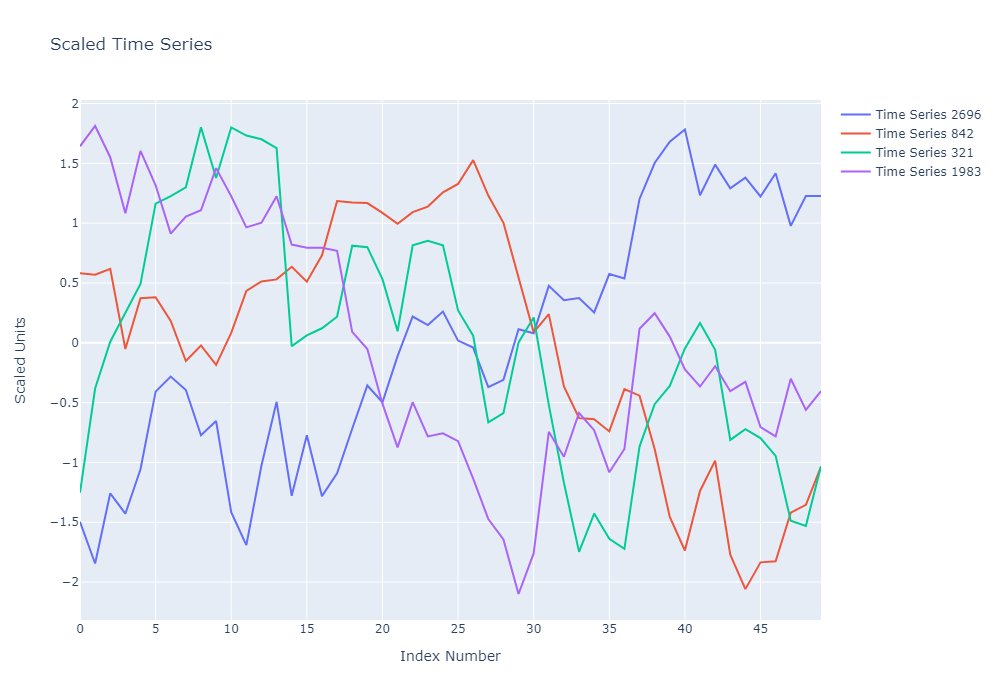 

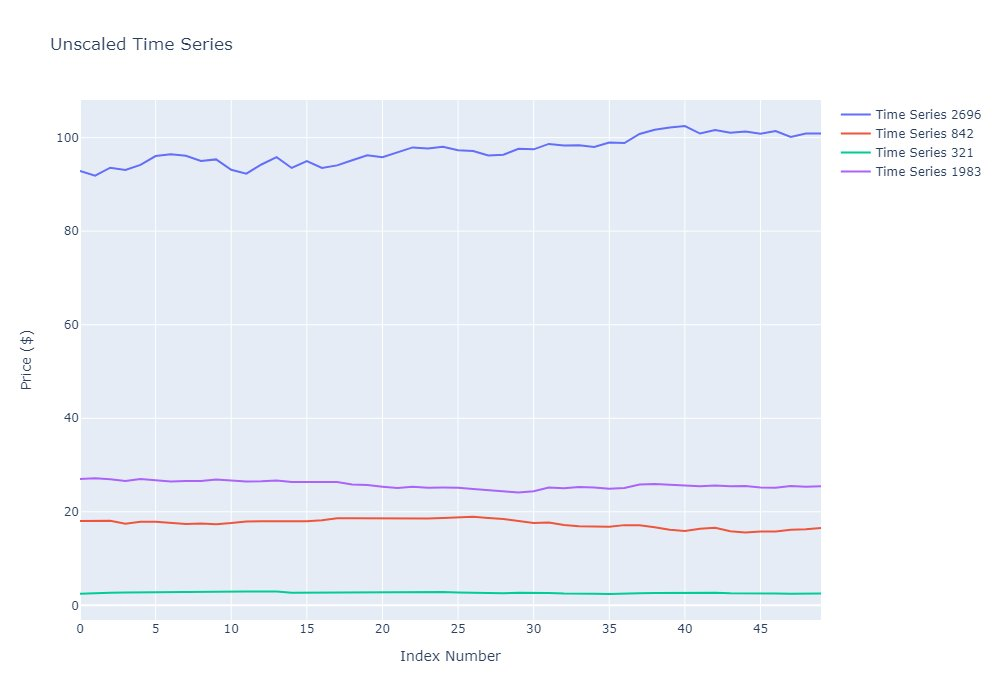

### 3a. Scaling

Once prices are on the same scale, seeing if one curve looks like another is easier

Since our goal is to find time-series similarity, scaling is a good idea

How do we scale?

Let's use standard scaling - the time series have a mean of 0 and standard deviation of 1

In [9]:
def standard_scale(x):
    
    mean = x.mean(axis = 1, keepdims = 1)
    std = x.std(axis = 1, keepdims = 1)
    
    x = (x - mean)/std
    
    #replace infinity with a large finite value
    x[x == np.inf] = 1e9
    x[x == -np.inf] = -1e9
    
    return x

#scale only the close time series, which is the first feature in the 3d array
x_train_scaled = x_train.copy()
x_train_scaled[:,:,0] = standard_scale(x_train[:,:,0])

x_test_scaled = x_test.copy()
x_test_scaled[:,:,0] = standard_scale(x_test[:,:,0])

### 3b. Scaling

Why this approach?

It tends to be a little less sensitive to outliers.

But at the end of the day, it's worth trying other ways too - because they could be better for your particular problem.

### 4. Clustering

Clustering is basically a way to sort data into groups.

However, we decide how many groups we want before we start 

Therefore, the big question is - how many groups do we need?

In [14]:
#!pip install kneed

In [16]:
#!pip install tslearn

In [11]:
import time
from kneed import KneeLocator
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

Clustering with k = 2
Inertia: 30.46616506713876
Time Taken: 2.8663339614868164

Clustering with k = 3
Inertia: 26.84216709313241
Time Taken: 8.499309301376343

Clustering with k = 4
Inertia: 24.196538603281525
Time Taken: 6.502610683441162

Clustering with k = 5
Inertia: 22.711368144883714
Time Taken: 4.85261082649231

Clustering with k = 6
Inertia: 21.78636833622323
Time Taken: 10.578706979751587

Clustering with k = 7
Inertia: 20.931895873946743
Time Taken: 10.861164569854736

Clustering with k = 8
Inertia: 20.31438681561282
Time Taken: 11.278830766677856

Clustering with k = 9
Inertia: 19.841232979282726
Time Taken: 7.889946937561035

Clustering with k = 10
Inertia: 19.314514304065145
Time Taken: 10.953802108764648

Clustering with k = 11
Inertia: 18.88314573080444
Time Taken: 12.365572214126587

Clustering with k = 12
Inertia: 18.631114720667302
Time Taken: 7.887964963912964

Clustering with k = 13
Inertia: 18.236744721672302
Time Taken: 9.428718328475952

Clustering with k = 14
I

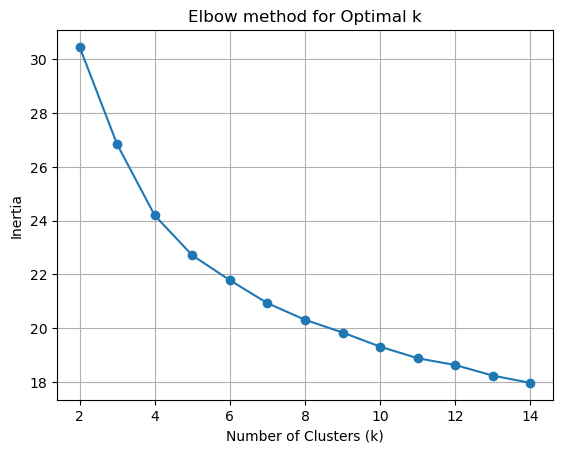

In [15]:
distance = []

clustering = []

t0 = time.time()
k_range = range(2,15)

for k in k_range:
    
    cluster_t0 = time.time()
    
    print('Clustering with k =', k)
    
    kmeans = TimeSeriesKMeans(
    n_clusters = k,
    metric = 'euclidean',
    random_state = 42,
    n_jobs = -1)
    
    kmeans.fit(x_train_scaled)
    
    clustering.append(kmeans)
    distance.append(kmeans.inertia_)
    
    print('Inertia:', kmeans.inertia_)
    print('Time Taken:', time.time() - cluster_t0)
    print('')
    
    
print('Overall fitting time:', time.time() - t0)

elbow_locator = KneeLocator(k_range, distance, curve = 'convex', direction = 'decreasing')
optimal_k = elbow_locator.elbow

print(f'\n Optimal k: {optimal_k}')

plt.plot(k_range, distance, marker = 'o')
plt.title('Elbow method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

### 4a. Clustering

Enter the elbow method

Basically, we fit by increasing K by 1 each time

Each fit gives a value which measures how compact the groupings are.

Lower the value = better fit. 

Or does it?

### 4b. Clustering

If we push it too far, every point is it's own cluster, which isn't very useful.

On the other hand, having too many clusters might lead to overfitting, and we want our model to be more general.

The kneed package sorts this out for us, choosing the K at the elbow

### 4c. Clustering

The whole fitting process took me 117 seconds - not too bad!

The optimal k was 5.

We can also see that cluster 1 is the most popular in train and 4 in test.

However, right now, this tells us nothing - let's view some charts!

In [17]:
optimal_kmeans = clustering[optimal_k - 2]

df_train['cluster'] = optimal_kmeans.predict(x_train_scaled)
df_test['cluster'] = optimal_kmeans.predict(x_test_scaled)

#cluster counts
print(df_train['cluster'].value_counts())
print(df_test['cluster'].value_counts())

1    974
4    956
0    798
2    508
3    481
Name: cluster, dtype: int64
4    208
1    193
0    126
3    112
2    108
Name: cluster, dtype: int64


### 5. Analyse the Clusters

Let's pick 4 random charts from cluster 0 - the highlight is the clustered point.

Clearly, it's picking some similarity - looks to me as if they're all in strong downtrends.

However, are they strikingly similar?

IMO - not really. Let's improve it.

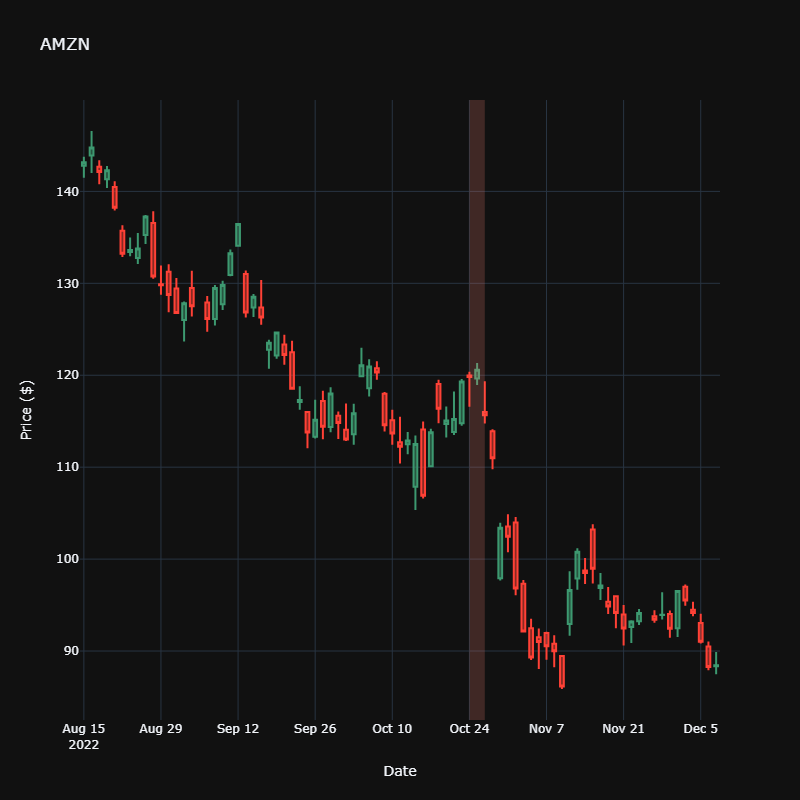

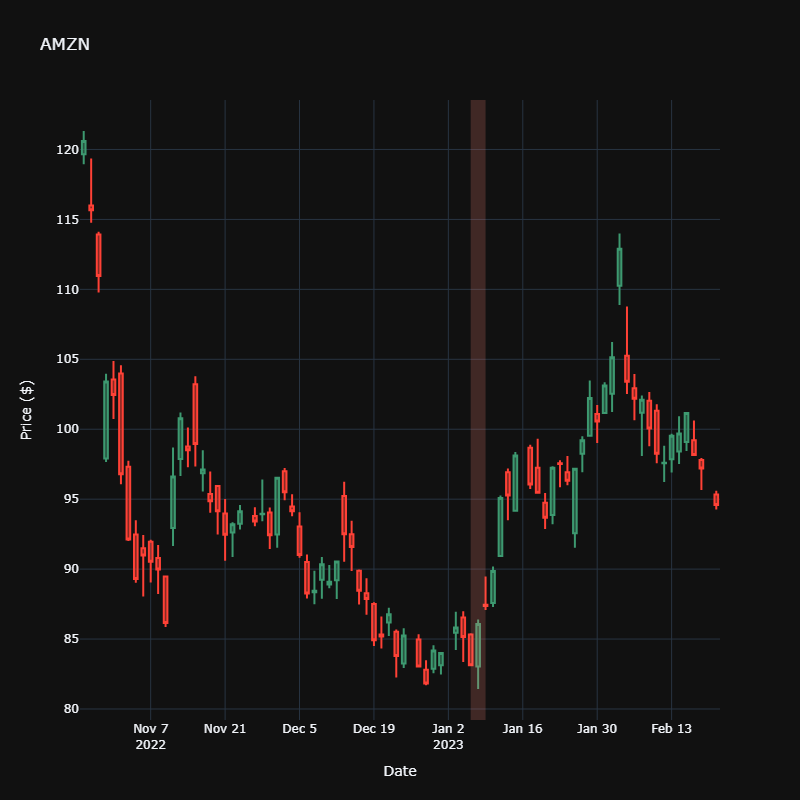

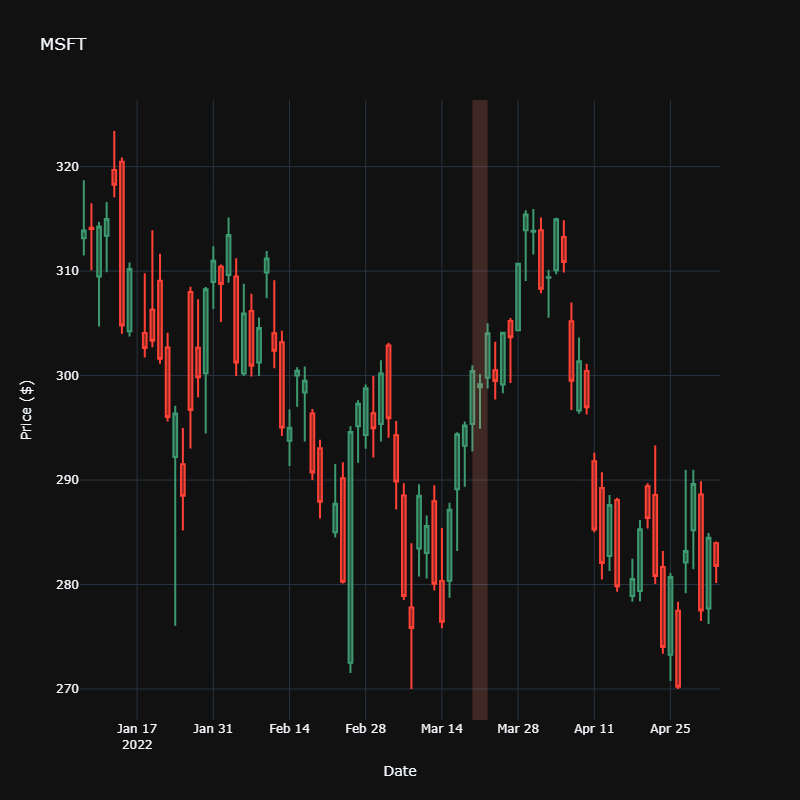

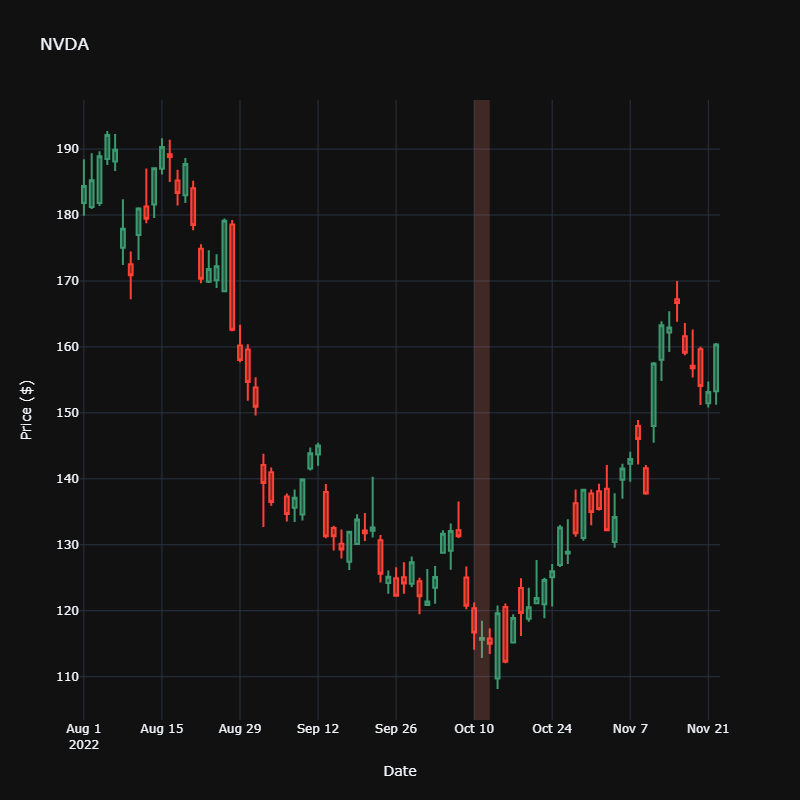

### 6. Improvement

My hypothesis is that there are simply more than 5 ways the time series can form in the market.

So perhaps the elbow method isn't too helpful here.

Instead - let's up the granularity and find many more clusters.

### 6a. Improvement

I chose 50 - you may ask why. I have no intelligent response.

The main reason was to just be more granular, and see if it helps!

After all, it's all exploration for now.

So, did it help? 

Let's explore with some charts.

In [19]:
granular_kmeans = TimeSeriesKMeans(n_clusters = 50,
                                  metric = 'euclidean',
                                  random_state = 42,
                                  n_jobs = -1,
                                  )

granular_kmeans.fit(x_train_scaled)

df_train['cluster_granular'] = granular_kmeans.predict(x_train_scaled)
df_test['cluster_granular'] = granular_kmeans.predict(x_test_scaled)

df_train['cluster_granular'].value_counts().sort_values(ascending = False).head()


44    190
37    181
41    158
46    157
1     153
Name: cluster_granular, dtype: int64

### 6b. Improvement

Since 44 was the most popular cluster, I decided to take 4 random charts from that.

The results are much better now.

There's definitely more similarity - all in uptrends with a pause in momentum.

Can we do better again?

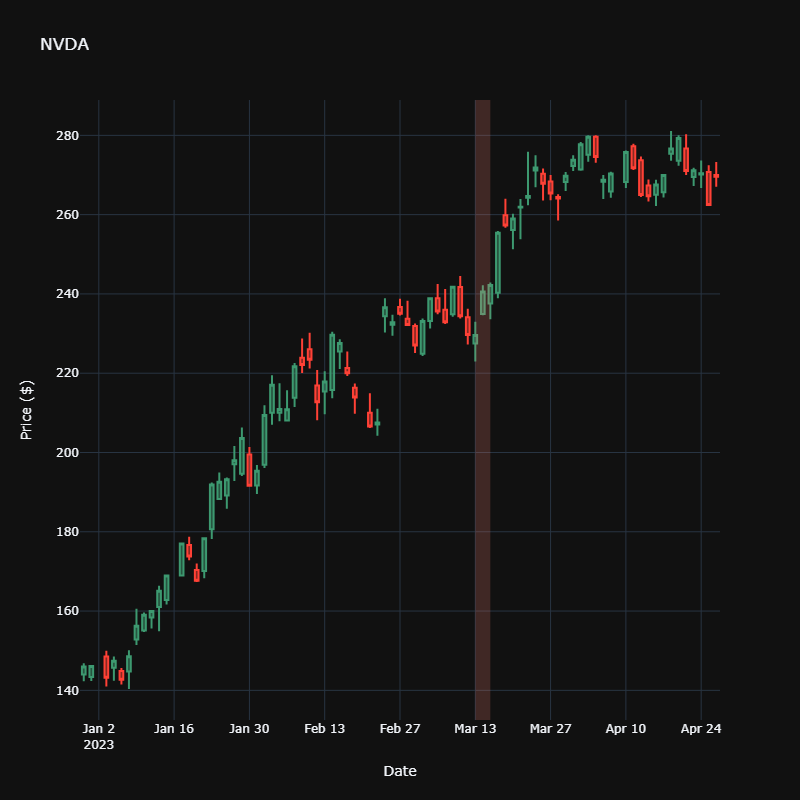

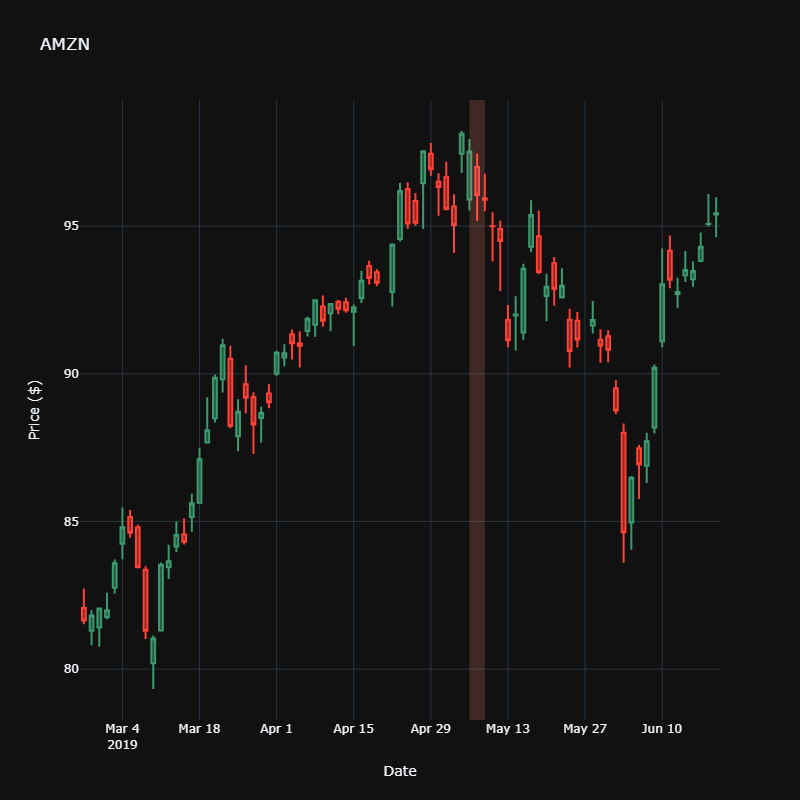

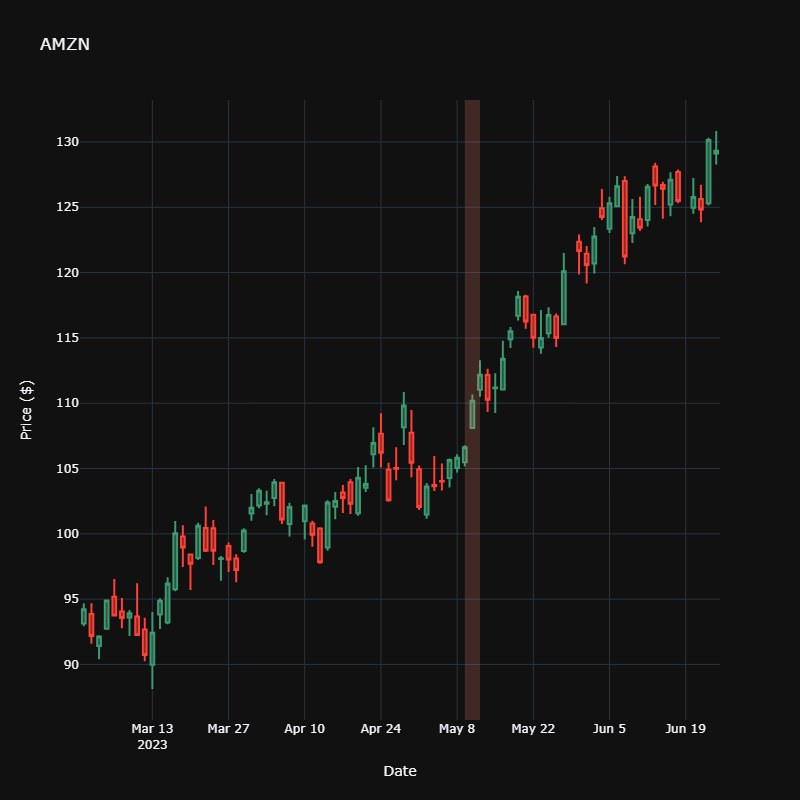

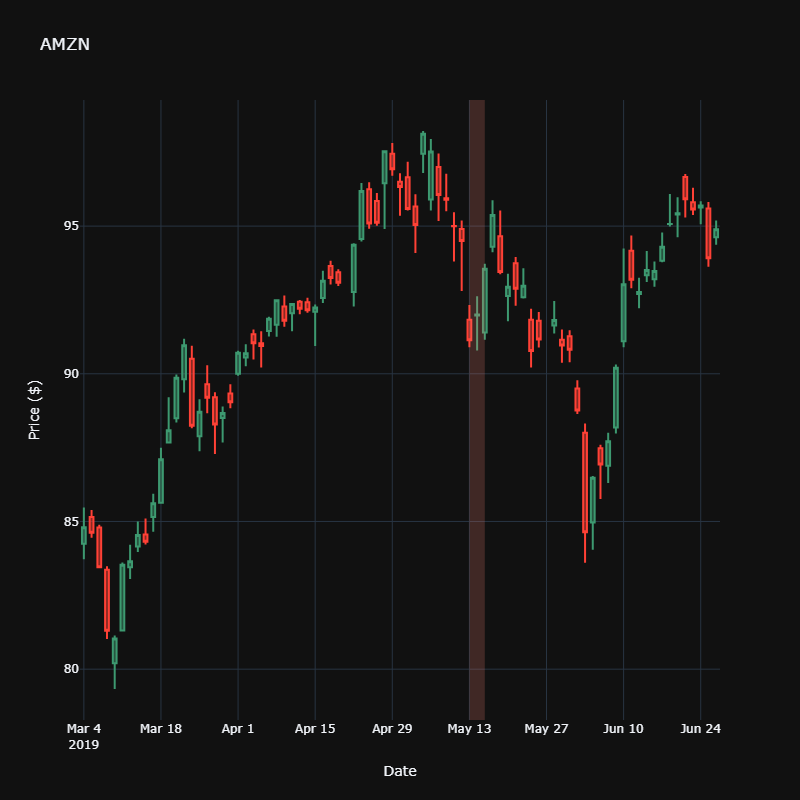

### 7. Dynamic Time Warping

Enter dynamic time warping (DTW).

DTW is a way of comparing two time series a little more robustly than other distance measures.

Let's break it down and explain why this is helpful.

https://twitter.com/i/status/1733852214756532368

### 7a. DTW

In pointwise matching, we would aim to get a distance measure by summing all the distances between each point.

However, if we shift the time series, the diffs on the y-axis may get large.

It's the same series, but the cost would be high.

https://twitter.com/i/status/1733852225250775182

### 7b. DTW

In DTW the points are matched up differently.

It's done in a way so that their y distance is smaller - it compares the two, equal time series efficiently even though they are shifted.

I won't go full into the details here, because that's easily another 

#### 7c. DTW

By the way, this also works on time series of different lengths, which is a nice perk (as not all time-series patterns are created equal).

The outcome of the method is a single number, the warping cost.

Smaller cost = more similar the time series.

#### 7d. DTW

Why am I explaining all this?

tslearn allows you to use dtw in the metric keyword argument.

With this, we should expect a more robust time series comparison!

In [ ]:
granular_kmeans = TimeSeriesKMeans(n_clusters = 50,
                                  metric = 'euclidean',
                                  random_state = 42,
                                  n_jobs = -1,
                                  )

granular_kmeans.fit(x_train_scaled)

df_train['cluster_granular'] = granular_kmeans.predict(x_train_scaled)
df_test['cluster_granular'] = granular_kmeans.predict(x_test_scaled)

df_train['cluster_granular'].value_counts().sort_values(ascending = False).head()
